In [1]:
import json
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


In [2]:
def get_essentia_files(folder, splits):
    folder_files = []
    for split in splits:
        with open(f'/home/laura/aimir/{folder}/{split}.txt', 'r') as f:
            folder_files += f.read().splitlines()
    
    essentia_files = [f'/home/laura/aimir/{folder}/essentia_features/{file}.json' for file in folder_files]
    return essentia_files

# Function to load JSON features
def load_features(files, dataset_label):
    features_list = []
    labels = []

    for file in files:
        if file.endswith('.json'):
            with open(file, 'r') as f:
                features = json.load(f)
                features_list.append(features)
                labels.append(dataset_label)

    # skip all '.cov' and '.icov' features and some metadata
    for i in range(len(features_list)):
        features_list[i].pop('lowlevel.gfcc.cov', None)
        features_list[i].pop('lowlevel.gfcc.icov', None)
        features_list[i].pop('lowlevel.mfcc.cov', None)
        features_list[i].pop('lowlevel.mfcc.icov', None)
        features_list[i].pop('metadata.tags.file_name', None)
        features_list[i].pop('metadata.audio_properties.md5_encoded', None)
        features_list[i].pop('metadata.version.essentia', None)
        features_list[i].pop('metadata.version.essentia_git_sha', None)
        features_list[i].pop('metadata.version.extractor', None)
        features_list[i].pop('metadata.tags.artist', None)
        features_list[i].pop('metadata.tags.title', None)
        features_list[i].pop('metadata.tags.genre', None)
        features_list[i].pop('metadata.tags.encoding', None)
        
    return features_list, labels

# Function to convert list of dicts to a DataFrame
def features_to_dataframe(features_list):
    df = pd.DataFrame(features_list)
    # if any feature is not scalar, expand it to multiple columns with the name {column_name}_{index}
    for column in df.columns:
        if not df[column].apply(lambda x: np.isscalar(x)).all():
            expanded = df[column].apply(pd.Series)
            expanded.columns = [f"{column}_{subcolumn}" for subcolumn in expanded.columns]
            df = pd.concat([df, expanded], axis=1)
            df = df.drop(column, axis=1)

    return df

In [3]:
# if '/home/laura/aimir/mess/essentia_features.csv' exists, load it
if os.path.exists('/home/laura/aimir/mess/essentia_features.csv'):
    df_features = pd.read_csv('/home/laura/aimir/mess/essentia_features.csv')
    df_labels = pd.read_csv('/home/laura/aimir/mess/essentia_labels.csv', header=None, names=['label'])

else:
    # Load features and labels for each dataset
    files_suno = get_essentia_files('suno', ['train', 'val', 'test'])
    features_suno, labels_suno = load_features(files_suno, 0)
    files_udio = get_essentia_files('udio', ['train', 'val', 'test'])
    features_udio, labels_udio = load_features(files_udio, 1)
    files_lastfm = get_essentia_files('lastfm', ['train', 'val', 'test'])
    features_lastfm, labels_lastfm = load_features(files_lastfm, 2)

    # Combine features and labels
    features_combined = features_suno + features_udio + features_lastfm
    labels_combined = labels_suno + labels_udio + labels_lastfm

    # Convert to DataFrame
    df_features = features_to_dataframe(features_combined)
    df_labels = pd.Series(labels_combined, name='label')

    # Handle missing values (if any)
    df_features = df_features.fillna(0)

    # handle string values in columns
    for column in df_features.columns:
        if df_features[column].dtype == 'object':
            # turn them into categorical values
            df_features[column] = df_features[column].astype('category').cat.codes

    # save the dataframes to disk
    df_features.to_csv('/home/laura/aimir/mess/essentia_features.csv', index=False)
    df_labels.to_csv('/home/laura/aimir/mess/essentia_labels.csv', index=False)

In [4]:
# if df_label starts with 'label', remove that
if 'label' in df_labels.columns[0]:
    df_labels = df_labels.drop(0)

In [5]:
df_features_feature_importance = df_features.copy()
# remove all 'metadata.audio_properties' columns
for column in df_features_feature_importance.columns:
    if column.startswith('metadata.audio_properties'):
        df_features_feature_importance = df_features_feature_importance.drop(column, axis=1)
        

# Split into training and testing sets (df_features without the labels)
X_train, X_test, y_train, y_test = train_test_split(df_features_feature_importance, df_labels, test_size=0.2, random_state=42, stratify=df_labels)

In [6]:

# encode labels to 0, 1, 2
y_train = y_train['label'].astype('category').cat.codes
y_test = y_test['label'].astype('category').cat.codes

print(y_train[:3])
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

12770    1
26333    2
17316    1
dtype: int8


RandomForestClassifier(random_state=42)

In [7]:
# Predict and evaluate the model
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# print true positive rate and true negative rate for each class
for i in range(3):
    print(f"Class {['suno', 'udio', 'lastfm'][i]}:")
    print(f"True positive rate: {np.sum((y_test == i) & (y_pred == i)) / np.sum(y_test == i)}")
    print(f"True negative rate: {np.sum((y_test != i) & (y_pred != i)) / np.sum(y_test != i)}")
print('confusion matrix:')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print(classification_report(y_test, y_pred, target_names=['suno', 'udio', 'lastfm'], digits=3))

# Get feature importance
feature_importance = pd.Series(clf.feature_importances_, index=df_features_feature_importance.columns)
important_features = feature_importance.sort_values(ascending=False)

# Display the most important features
print("Top 10 Important Features:")
print(important_features.head(10))
# add the labels to the features dataframe as a column
merged_df = pd.concat([df_features.reset_index(), df_labels.reset_index()], axis=1)

# for each of the features, print the mean and std value for each class
for feature in important_features.index[:10]:
    print(f"Feature: {feature}")
    for i in range(3):
        print(f"Class {['suno', 'udio', 'lastfm'][i]}:")
        feature_values = merged_df[merged_df['label'] == str(i)][feature]
        print(f"Mean: {round(feature_values.mean(),3)}")
        print(f"Std: {round(feature_values.std(),3)}")
    print()

Accuracy: 0.9251666666666667
Class suno:
True positive rate: 0.962
True negative rate: 0.986
Class udio:
True positive rate: 0.9095
True negative rate: 0.948
Class lastfm:
True positive rate: 0.904
True negative rate: 0.95375
confusion matrix:
Predicted     0     1     2   All
True                             
0          1924    44    32  2000
1            28  1819   153  2000
2            28   164  1808  2000
All        1980  2027  1993  6000
              precision    recall  f1-score   support

        suno      0.972     0.962     0.967      2000
        udio      0.897     0.909     0.903      2000
      lastfm      0.907     0.904     0.906      2000

    accuracy                          0.925      6000
   macro avg      0.925     0.925     0.925      6000
weighted avg      0.925     0.925     0.925      6000

Top 10 Important Features:
lowlevel.melbands_skewness.stdev     0.022666
lowlevel.melbands_kurtosis.stdev     0.020042
lowlevel.barkbands_skewness.stdev    0.017878
lowlev

Mean: 2.277
Std: 1.093
Class lastfm:
Mean: 2.4
Std: 13.359

Feature: lowlevel.melbands_kurtosis.stdev
Class suno:
Mean: 3629.79
Std: 3695.051
Class udio:
Mean: 62.677
Std: 540.608
Class lastfm:
Mean: 3135.252
Std: 258781.733

Feature: lowlevel.barkbands_skewness.stdev
Class suno:
Mean: 10.443
Std: 6.644
Class udio:
Mean: 1.813
Std: 0.909
Class lastfm:
Mean: 1.694
Std: 1.162

Feature: lowlevel.barkbands_kurtosis.stdev
Class suno:
Mean: 1507.702
Std: 1304.254
Class udio:
Mean: 37.288
Std: 250.127
Class lastfm:
Mean: 49.091
Std: 622.863

Feature: lowlevel.erbbands.stdev_39
Class suno:
Mean: 0.0
Std: 0.0
Class udio:
Mean: 0.001
Std: 0.003
Class lastfm:
Mean: 0.0
Std: 0.0

Feature: lowlevel.erbbands.stdev_38
Class suno:
Mean: 0.005
Std: 0.01
Class udio:
Mean: 0.013
Std: 0.038
Class lastfm:
Mean: 0.001
Std: 0.003

Feature: lowlevel.barkbands_kurtosis.mean
Class suno:
Mean: 210.368
Std: 353.952
Class udio:
Mean: 10.013
Std: 18.507
Class lastfm:
Mean: 11.149
Std: 73.225

Feature: lowlevel.erbb

In [21]:
# Reindex df_labels to match df_features
df_labels = df_labels.reindex(df_features.index)

labels_names = ['suno', 'udio', 'lastfm']
for i in ['0', '1', '2']:
    print(f"Label {labels_names[int(i)]} sample rate values")
    
    # Create a mask for the current label
    mask = df_labels['label'] == i
    
    # Use the mask to filter df_features
    filtered_df = df_features[mask]
    
    # Print value counts and percentages
    print(filtered_df['metadata.audio_properties.sample_rate'].value_counts())
    print(filtered_df['metadata.audio_properties.sample_rate'].value_counts(normalize=True))

# give the bit_rate mean and std for each class
for i in range(3):
    print(f"Class {['suno', 'udio', 'lastfm'][i]}:")
    bit_rate_values = merged_df[merged_df['label'] == str(i)]['metadata.audio_properties.bit_rate']
    print(f"Mean: {round(bit_rate_values.mean(),3)}")
    print(f"Std: {round(bit_rate_values.std(),3)}")
    print()

Label suno sample rate values
metadata.audio_properties.sample_rate
48000.0    9997
44100.0       3
Name: count, dtype: int64
metadata.audio_properties.sample_rate
48000.0    0.9997
44100.0    0.0003
Name: proportion, dtype: float64
Label udio sample rate values
metadata.audio_properties.sample_rate
48000.0    9999
44100.0       1
Name: count, dtype: int64
metadata.audio_properties.sample_rate
48000.0    0.9999
44100.0    0.0001
Name: proportion, dtype: float64
Label lastfm sample rate values
metadata.audio_properties.sample_rate
44100.0    5952
48000.0    4047
Name: count, dtype: int64
metadata.audio_properties.sample_rate
44100.0    0.59526
48000.0    0.40474
Name: proportion, dtype: float64
Class suno:
Mean: 192000.0
Std: 0.0

Class udio:
Mean: 320000.0
Std: 0.0

Class lastfm:
Mean: 140865.663
Std: 43478.499



In [22]:
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(features_df, labels_df, features_to_plot, replace, save=False):
    features_df = features_df.rename(columns=replace)
    features_to_plot = [replace[feature] for feature in features_to_plot]
    features_df['label'] = labels_df

    fig = plt.figure(figsize=(20, 8))
    plt.rcParams.update({'font.size': 16})
    
    def format_time(x, _):
        minutes = int(x // 60)
        seconds = int(x % 60)
        return f'{minutes:02d}:{seconds:02d}'

    # Create a dummy plot to get legend elements
    dummy_ax = fig.add_subplot(111)
    dummy_plot = sns.histplot(data=features_df, x=features_to_plot[0], hue='label', 
                            kde=True, element='step', palette='Set1', ax=dummy_ax)
    legend = dummy_plot.get_legend()
    dummy_ax.remove()  # Remove the dummy plot
    
    for i, feature in enumerate(features_to_plot):
        ax = plt.subplot(2, len(features_to_plot) // 2, i + 1)
        
        if feature == 'Duration (s)':
            filtered_data = features_df[features_df[feature] <= 900]
            sns.histplot(data=filtered_data, x=feature, hue='label', kde=True, 
                        element='step', palette='Set1', legend=False)
            
            plt.gca().xaxis.set_major_formatter(FuncFormatter(format_time))
            plt.xlabel('Duration (mm:ss)')
        
        elif feature == 'Dynamic Complexity':
            sns.histplot(data=features_df, x=feature, hue='label', kde=True, 
                        element='step', palette='Set1', legend=False)
            
        elif feature == 'Spectral Centroid':
            sns.histplot(data=features_df, x=feature, hue='label', kde=True, 
                        element='step', palette='Set1', legend=False)
            
        else:
            sns.histplot(data=features_df, x=feature, hue='label', kde=True, 
                        element='step', palette='Set1', legend=False)
        
        if feature in ['Duration (s)', 'Dynamic Complexity', 'Spectral Centroid']:
            ax.set_xlim(0, features_df[feature].quantile(0.995))
            ax.set_xticks(np.linspace(0, features_df[feature].quantile(0.995), 5))
        elif feature in ['BPM']:
            ax.set_xticks(np.arange(50, 210, 50))
    
    plt.figlegend(legend.legendHandles, ['suno', 'udio', 'msd'], 
                  bbox_to_anchor=(0.95, 0.5), loc='center left')
    
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    
    if save:
        plt.savefig('/home/laura/aimir/figures/feature_distributions.pdf', 
                    bbox_inches='tight', pad_inches=0.2)
        
    plt.show()

/tmp/ipykernel_3302890/3508400018.py:55: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  plt.figlegend(legend.legendHandles, ['suno', 'udio', 'msd'],


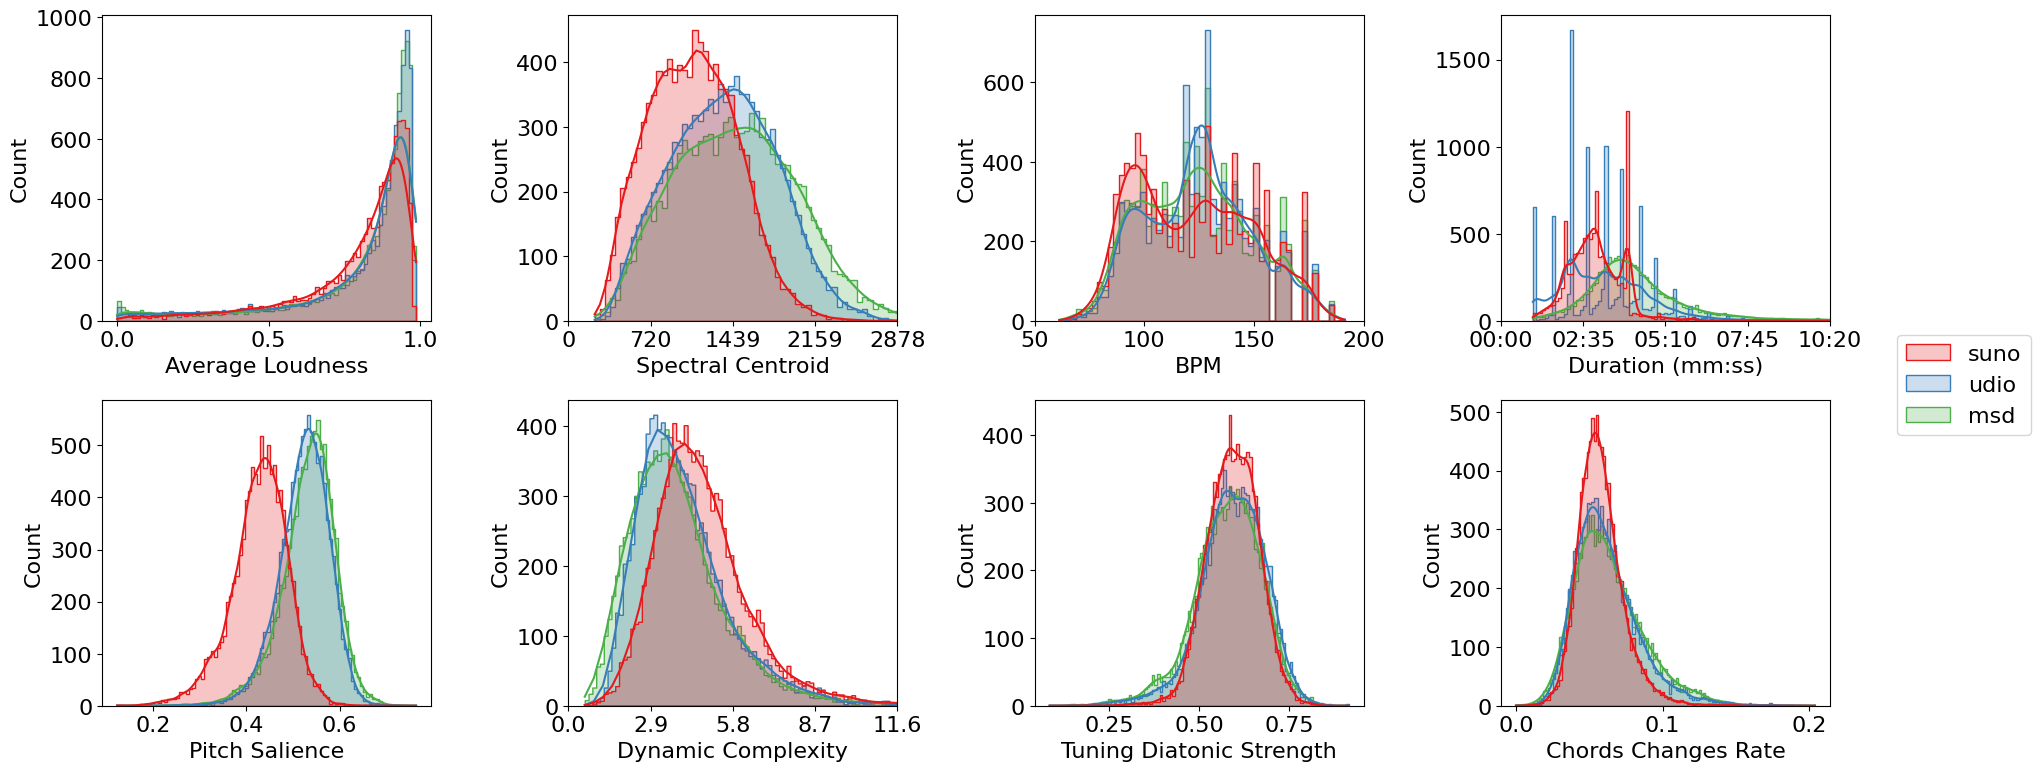

In [23]:
features_to_plot = ['lowlevel.average_loudness', 'lowlevel.spectral_centroid.mean', 'rhythm.bpm', 'metadata.audio_properties.length', 'lowlevel.pitch_salience.mean', 'lowlevel.dynamic_complexity', 'tonal.tuning_diatonic_strength', 'tonal.chords_changes_rate']
replace = {'lowlevel.average_loudness': 'Average Loudness', 'lowlevel.spectral_centroid.mean': 'Spectral Centroid', 'rhythm.bpm': 'BPM', 'metadata.audio_properties.length': 'Duration (s)', 'lowlevel.pitch_salience.mean': 'Pitch Salience', 'lowlevel.dynamic_complexity': 'Dynamic Complexity', 'tonal.tuning_diatonic_strength': 'Tuning Diatonic Strength', 'tonal.chords_changes_rate': 'Chords Changes Rate'}
plot_feature_distributions(df_features, df_labels, features_to_plot, replace, save=True)

In [24]:
# print the histogram for BPM for each label
for i in range(3):
    print(f"Label {['suno', 'udio', 'msd'][i]} BPM values")
    # in bins of 10
    print(df_features[i*10000:i*10000+10000]['rhythm.bpm'].value_counts(bins=10, sort=True)[:3])
    

Label suno BPM values
(88.86, 101.679]      2089
(127.315, 140.133]    1643
(114.497, 127.315]    1360
Name: count, dtype: int64
Label udio BPM values
(114.724, 127.504]    2165
(127.504, 140.285]    2112
(89.163, 101.943]     1520
Name: count, dtype: int64
Label msd BPM values
(113.299, 126.317]    1867
(126.317, 139.335]    1710
(87.264, 100.281]     1627
Name: count, dtype: int64


In [28]:
# print the features_to_plot in a latex table, as $mean \pm std$
def features_to_latex_table(features_df, df_labels, features_to_plot, replace):
    # change features_df and features_to_plot to make them more readable
    features_df = features_df.rename(columns=replace)
    features_to_plot = [replace[feature] for feature in features_to_plot]

    # Set up the plotting environment
    print(r'\begin{tabular}{l c c c}')
    print(r'\toprule')
    print(r'Feature & Suno & Udio & Lastfm \\')
    print(r'\midrule')
    
    for feature in features_to_plot:
        row = f"{feature} & "
        for i in ['suno', 'udio', 'lastfm']:
            mean = features_df[df_labels['label'] == i][feature].mean()
            std = features_df[df_labels['label'] == i][feature].std()
            row += f"${mean:.3f} \pm {std:.3f}$ & "
        row = row[:-2] + r'\\'
        print(row)
    
    print(r'\bottomrule')
    print(r'\end{tabular}')

features_to_latex_table(df_features, df_labels, features_to_plot, replace)

\begin{tabular}{l c c c}
\toprule
Feature & Suno & Udio & Lastfm \\
\midrule


Average Loudness & $0.787 \pm 0.197$ & $0.798 \pm 0.224$ & $0.800 \pm 0.226$ \\
Spectral Centroid & $1091.129 \pm 385.574$ & $1366.085 \pm 457.404$ & $1501.280 \pm 631.933$ \\
BPM & $122.257 \pm 26.432$ & $124.846 \pm 23.648$ & $123.899 \pm 24.926$ \\
Duration (mm:ss) & $180.370 \pm 58.875$ & $196.579 \pm 87.545$ & $260.443 \pm 146.521$ \\
Pitch Salience & $0.428 \pm 0.061$ & $0.524 \pm 0.054$ & $0.533 \pm 0.058$ \\
Dynamic Complexity & $4.735 \pm 1.859$ & $4.053 \pm 1.699$ & $3.888 \pm 2.013$ \\
Tuning Diatonic Strength & $0.594 \pm 0.072$ & $0.593 \pm 0.091$ & $0.579 \pm 0.094$ \\
Chords Changes Rate & $0.058 \pm 0.016$ & $0.062 \pm 0.022$ & $0.064 \pm 0.024$ \\
\bottomrule
\end{tabular}
